# NETWORK ANALYSIS AND RECOMMENDATION SYSTEM FOR AMAZON PRODUCTS

**MUSTECEP BERCA AKBAYIR**

**52448A**

In [1]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import community.community_louvain as community_louvain
import networkx as nx
import matplotlib.cm as cm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.model_selection import train_test_split
from itertools import combinations
import random
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import lightgbm as lgb


/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Loading the Graph

In [2]:
product_mappings = pd.read_csv('./unimi-dse-ns-assignment/amazon_products.csv')

In [3]:
def map_ids_to_names(ids):
    """
    Convert a list of product IDs to a list of (product_name, group) tuples.
    If an ID is missing, returns ('Unknown-ID', 'Unknown').
    """
    return [id_to_info.get(pid, (f"Unknown-{pid}", "Unknown")) for pid in ids]

In [4]:


# Read the tab-separated edge list
edges_df = pd.read_csv(
    "./unimi-dse-ns-assignment/Amazon0302.txt",
    sep="\t",
    comment='#',
    names=['FromNodeId', 'ToNodeId'],
    dtype={'FromNodeId': 'int32', 'ToNodeId': 'int32'}
)

G = nx.from_pandas_edgelist(
    edges_df,
    source='FromNodeId',
    target='ToNodeId',
    create_using=nx.DiGraph()
)

print(G)


DiGraph with 262111 nodes and 1234877 edges


In [5]:
edges_df

,FromNodeId,ToNodeId
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
1234872,262110,262099
1234873,262110,262100
1234874,262110,262101
1234875,262110,262106


In [6]:
edges_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234877 entries, 0 to 1234876
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype
---  ------      --------------    -----
 0   FromNodeId  1234877 non-null  int32
 1   ToNodeId    1234877 non-null  int32
dtypes: int32(2)
memory usage: 9.4 MB


In [7]:
edges_df.isnull().sum()

FromNodeId    0
ToNodeId      0
dtype: int64

In [8]:
edges_df.shape

(1234877, 2)

In [9]:
edges_df.duplicated().sum()

0

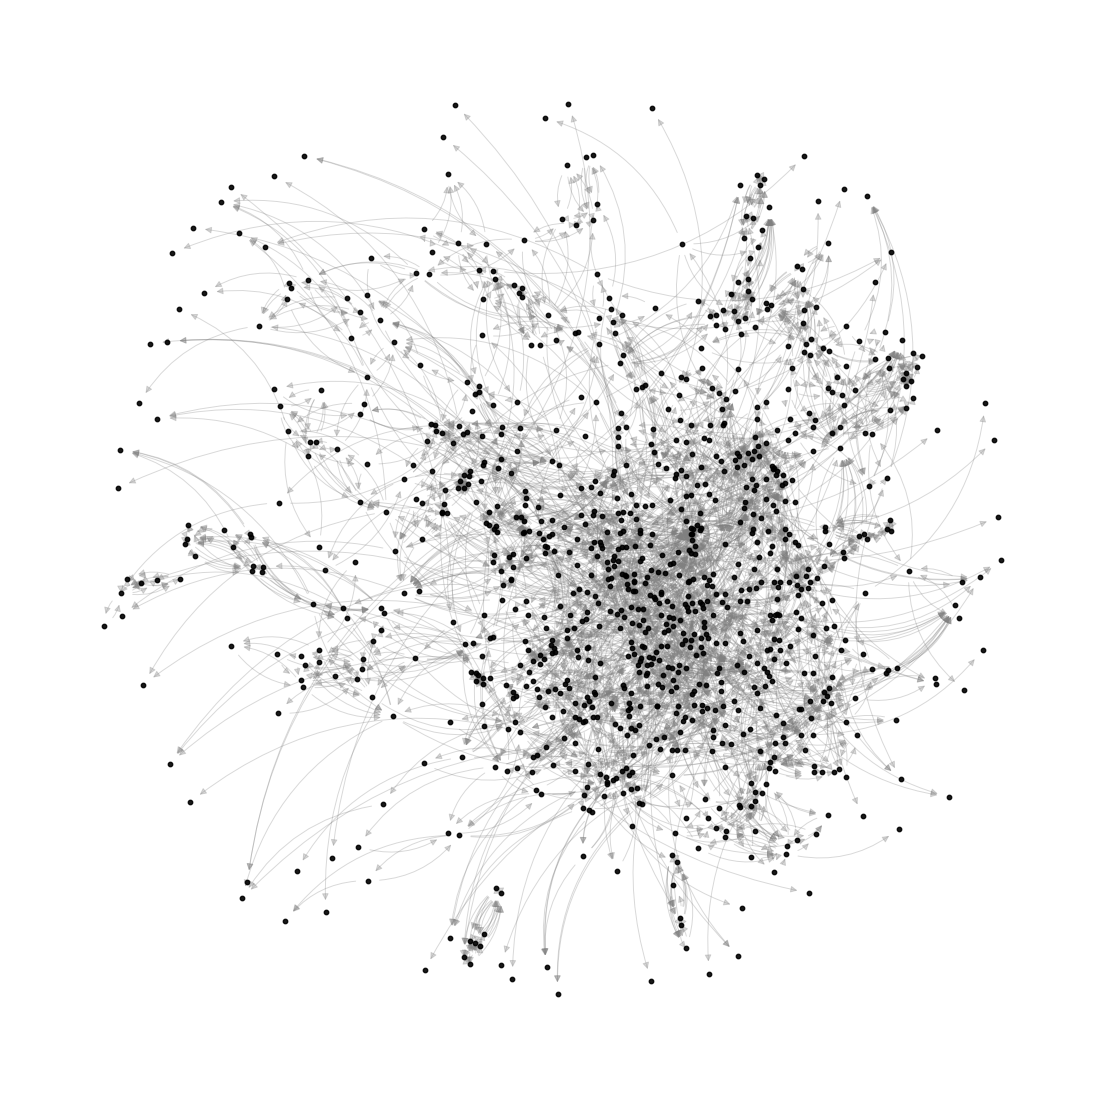

In [10]:
sub_G = G.subgraph(list(G.nodes())[:1000])

plt.figure(figsize=(14, 14))
pos = nx.spring_layout(sub_G, k=0.1, iterations=50)

# Draw black nodes
nx.draw_networkx_nodes(
    sub_G,
    pos,
    node_size=10,
    node_color="black",
    alpha=0.9
)

# Draw curved (elliptic) edges
nx.draw_networkx_edges(
    sub_G,
    pos,
    edge_color="gray",
    alpha=0.3,
    width=0.7,
    connectionstyle="arc3,rad=0.25"
)

plt.axis("off")
plt.show()


In [11]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Density: {nx.density(G):.6f}")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

Number of nodes: 262111
Number of edges: 1234877
Density: 0.000018
Average degree: 9.42


Number of unique products is 262111 in the subset of the network (node=product)

Each edge represents a “customers who bought product i also bought product j” relationship.

With ~1.23M edges for ~262k nodes, each product is connected to multiple co-purchased products.

Most products are co-purchased with only a small fraction of all products. degree is too low, graph is too sparse as expected in real world.

On average, each product is connected to ~9 other products (considering both in-degree + out-degree).

# Degree Based Analysis

In [12]:
# Assuming you already have product_mappings DataFrame loaded
id_to_info = dict(zip(product_mappings['id'], zip(product_mappings['product_name'], product_mappings['group'])))


# Compute in/out degrees
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Top 5 most co-purchased products
top_in = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
top_out = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]

# Map IDs to names using the function
top_in_mapped = [(map_ids_to_names([pid])[0], count) for pid, count in top_in]
top_out_mapped = [(map_ids_to_names([pid])[0], count) for pid, count in top_out]

# Print results
print("Top 5 most co-purchased products (with names and groups):")
print("-----------------------------------------------------------")
for info, count in top_in_mapped:
    print(f"{info[0]} ({info[1]}), purchases: {count}")
    
print('\n===========================================================')

print("\nTop 5 products with most co-purchases from them (with names and groups):")
print("-----------------------------------------------------------")
for info, count in top_out_mapped:
    print(f"{info[0]} ({info[1]}), purchases: {count}")


Top 5 most co-purchased products (with names and groups):
-----------------------------------------------------------
Fodor's Australia 2000 (Book), purchases: 420
Harley-Davidson Panheads, 1948-1965/M418 (Book), purchases: 404
Double Jeopardy (T*Witches, 6) (Book), purchases: 361
Pilgrim (Music), purchases: 334
Jorge Negrete (Book), purchases: 330


Top 5 products with most co-purchases from them (with names and groups):
-----------------------------------------------------------
Unknown-0 (Unknown), purchases: 5
Patterns of Preaching: A Sermon Sampler (Book), purchases: 5
Candlemas: Feast of Flames (Book), purchases: 5
World War II Allied Fighter Planes Trading Cards (Book), purchases: 5
Life Application Bible Commentary: 1 and 2 Timothy and Titus (Book), purchases: 5


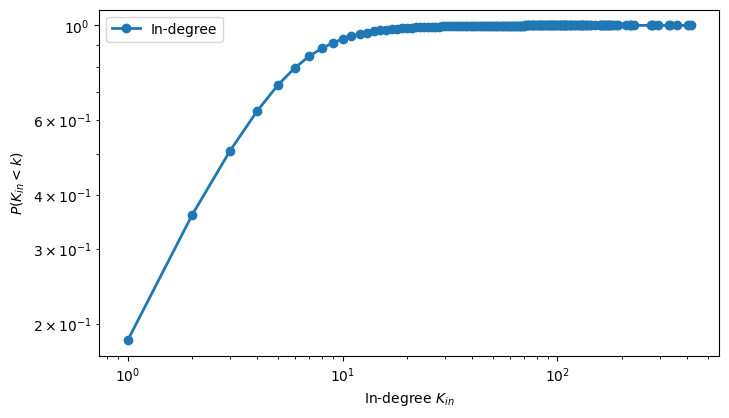

In [13]:
in_deg_sample = np.array(list(in_degrees.values()))
x_in = np.unique(in_deg_sample)
y_in = np.array([np.mean(in_deg_sample <= k) for k in x_in])

plt.figure(figsize=(8,4.5))
plt.loglog(x_in, y_in, marker='o', lw=2, label='In-degree')
plt.xlabel('In-degree $K_{in}$')
plt.ylabel('$P(K_{in} < k)$')

plt.legend()
plt.show()


This plot shows how many nodes have an in-degree less than or equal to each value. It rises because more and more nodes are included as the degree gets larger. The shape tells you that most nodes have low in-degree, fewer have medium in-degree, and only a small number reach high in-degree. In short, the network is mostly made of low-connected nodes with a gradual tail of more connected ones.

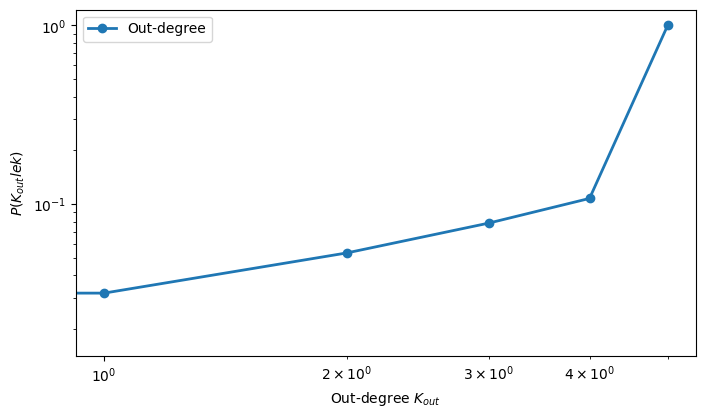

In [14]:
# Correct out-degree sample
out_deg_sample = np.array(list(out_degrees.values()))

# Unique degrees
x_out = np.unique(out_deg_sample)

# ECDF for each unique degree
y_out = np.array([np.mean(out_deg_sample <= k) for k in x_out])

# Plot
plt.figure(figsize=(8,4.5))
plt.loglog(x_out, y_out, marker='o', lw=2, label='Out-degree')
plt.xlabel('Out-degree $K_{out}$')
plt.ylabel(r'$P(K_{out} le k)$')  # raw string for \le
plt.legend()
plt.show()


This plot shows the empirical cumulative distribution function (ECDF) of the out-degrees in a network, plotted on a log-log scale. The x-axis represents the out-degree K_out (the number of outgoing connections from a node), and the y-axis represents the probability P(K_out≤k) that a randomly chosen node has an out-degree less than or equal to k. The curve illustrates how out-degrees are distributed across the network; a steep rise at lower degrees indicates that most nodes have few outgoing links, while the long tail suggests a small number of nodes have many outgoing connections. This pattern is characteristic of many real-world networks, such as social or web networks, where connectivity is often highly uneven.


# Connectivity Analysis

In [15]:
print("Number of weakly connected components:", nx.number_weakly_connected_components(G))
print("Number of strongly connected components:", nx.number_strongly_connected_components(G))


Number of weakly connected components: 1
Number of strongly connected components: 6594


In the graph, there is only one weakly connected component. It means there is only one big connected structure when directions of edges are ignored. On the other hand, there are 6594 strongly connected component. It means there are 6594 strongly connected structures in network. Probably all these components are small networks without return or have rare feedback loops as expected in typical directed networks.

## Largest Weakly Connected Component

In [16]:
components_w = list(nx.weakly_connected_components(G))
largest_wcc = max(components_w, key=len)

print("Size of Large Weakly Connected Components:", len(largest_wcc))

LWCC_subgraph = G.subgraph(largest_wcc).copy()


Size of Large Weakly Connected Components: 262111


The entire graph forms a single weakly connected component. Every product is reachable from every other product if you ignore edge direction.

## Largest Strongly Connected Component

In [17]:
components_s = list(nx.strongly_connected_components(G))
largest_scc = max(components_s, key=len)

print("Size of Largest Strongly Connected Component:", len(largest_scc))

LSCC_subgraph = G.subgraph(largest_scc).copy()


Size of Largest Strongly Connected Component: 241761


Out of 262,111 nodes in total, 241,761 (~92%) form the largest SCC.

Most products are mutually reachable via co-purchase paths, not just weakly connected.

## Giant Components

In [18]:
n = G.number_of_nodes()

giant_W_ratio = len(largest_wcc) / n
giant_S_ratio = len(largest_scc) / n

print("Weak giant component ratio:", giant_W_ratio)
print("Strong giant component ratio:", giant_S_ratio)


Weak giant component ratio: 1.0
Strong giant component ratio: 0.9223611370755138


The entire network (100% of nodes) belongs to the largest weakly connected component (WCC).

This confirms that if we ignore edge directions, all products are interconnected, and there are no isolated clusters.

About 92% of nodes belong to the largest strongly connected component (LSCC).

Most products are mutually reachable via co-purchase paths, forming a core network.

## Assortativity

In [19]:
assortativity = nx.degree_assortativity_coefficient(G)
print("Degree Assortativity:", assortativity)

Degree Assortativity: 0.0026772436574012287


Positive degree assortativity shows that High-degree nodes likely connect to high-degree nodes but in this case degree assortativity is very close to zero. It means High-degree nodes do not preferentially attach to other high-degree nodes or Low-degree nodes do not preferentially attach to other low-degree nodes. Graph behaves like random graph at this moment.

# Centrality Analysis

## Degree Centrality

In [20]:
deg_centrality = nx.degree_centrality(G)

## PageRank Centrality

In [21]:
pagerank = nx.pagerank(G, alpha=0.85)

## Eigenvector Centrality

In [22]:
eigenvector_centrality = nx.eigenvector_centrality( G, max_iter=500)

## Betweenness Centrality

In [23]:
betweenness_centrality = nx.betweenness_centrality(G, k=500, seed=42)

## Closeness Centrality

In [24]:
sample_nodes = random.sample(list(G.nodes()), 500)
approx_closeness = {v: nx.closeness_centrality(G, u=v) for v in sample_nodes}

In [25]:
centrality_df = pd.DataFrame({
    'degree': pd.Series(deg_centrality),
    'pagerank': pd.Series(pagerank),
    'eigenvector': pd.Series(eigenvector_centrality),
    'betweenness': pd.Series(betweenness_centrality),
    'closeness': pd.Series(approx_closeness)
})

## Correlations of Centrality Measurements

In [26]:
corr_matrix = centrality_df.corr()

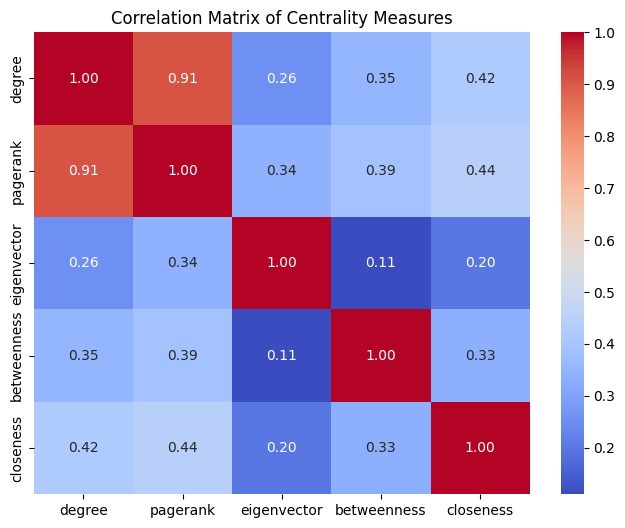

In [27]:


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Centrality Measures")
plt.show()

In [28]:
def top_n_ranks(centrality, n=20):
    return sorted(centrality, key=centrality.get, reverse=True)[:n]

In [29]:
corr_matrix

,degree,pagerank,eigenvector,betweenness,closeness
degree,1.000000,0.908419,0.255974,0.350909,0.421476
pagerank,0.908419,1.000000,0.337177,0.389874,0.443284
eigenvector,0.255974,0.337177,1.000000,0.110437,0.199188
betweenness,0.350909,0.389874,0.110437,1.000000,0.334426
closeness,0.421476,0.443284,0.199188,0.334426,1.000000


Degree ↔ PageRank: 0.908 : Very high correlation → nodes with many connections also tend to be highly “important” in PageRank.

Makes sense in co-purchase networks: popular items (high in-degree) are also central for recommendation flows.

Degree ↔ Eigenvector: 0.256 : Low correlation → having many connections doesn’t necessarily mean connecting to other highly connected nodes.

Suggests a hub-and-spoke structure: many products point to central hubs, but hubs aren’t densely interconnected.

Eigenvector centrality : orrelates weakly with most measures (0.11–0.34) → the network is not a dense cluster; it has a few hubs and many peripheral nodes, consistent with a hierarchical hub structure.

Degree ↔ Betweenness = 0.35

PageRank ↔ Betweenness = 0.39

This tells you that bridging items are not necessarily the popular ones.
In a co-purchase setting, these are likely niche items that connect different product subcategories rather than high-traffic items.

# Clustering Coefficients and Triangle Analysis

In [30]:
G_undirected = G.to_undirected()


global_clustering_coefficient = nx.transitivity(G_undirected)
print("Global Clustering Coefficient:", global_clustering_coefficient)

# --- Average clustering coefficient ---
avg_clustering = nx.average_clustering(G_undirected)
print("Average Clustering Coefficient:", avg_clustering)



Global Clustering Coefficient: 0.23608271612383297
Average Clustering Coefficient: 0.419780014607673


Global clustering coefficient is 0.236. It means 23.6% of the time, if item A is co-purchased with B and B with C, then A is also co-purchased with C.

Average Clustering Coefficient is 0.42. It means on average, each item’s neighbors have a 42% chance of being co-purchased with each other.

In [31]:
triangles_per_node = nx.triangles(G_undirected)
total_triangles = sum(triangles_per_node.values()) // 3
print("Total number of triangles:", total_triangles)

Total number of triangles: 717719


The total number of triangles represents that Many items form small, highly interconnected co-purchase groups.

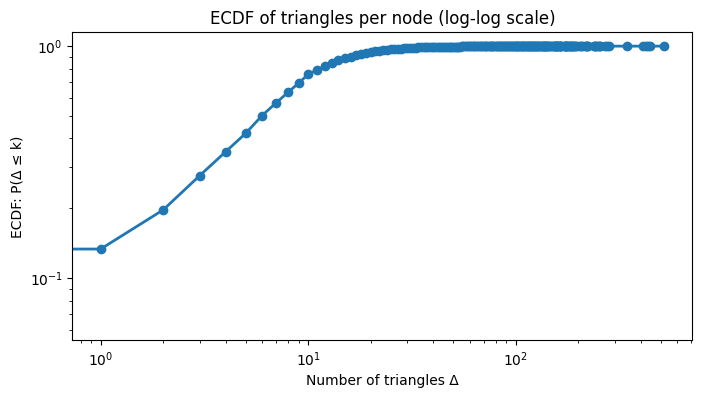

In [32]:
triangle_values = list(triangles_per_node.values())

# Compute ECDF
ecdf = ECDF(triangle_values)

x = np.unique(triangle_values)
y = ecdf(x)

# Plot on log-log scale
fig, ax = plt.subplots(figsize=(8,4))
ax.loglog(x, y, lw=2, ls='-', marker='o')
ax.set_xlabel('Number of triangles Δ')
ax.set_ylabel('ECDF: P(Δ ≤ k)')
ax.set_title('ECDF of triangles per node (log-log scale)')
plt.show()


This is a log-log plot showing the Empirical Cumulative Distribution Function (ECDF) for the number of triangles per node in a network. The curve rises sharply at the left, meaning that a large majority of nodes participate in very few triangles. The long, slow tail to the right indicates that a very small subset of nodes is part of a surprisingly large number of triangles.

This pattern tells you that your network has a common "core-periphery" structure. A small, densely connected core of users or items (the tail) is embedded in rich local clusters, while most of the network is sparse. For recommendations, this means two things: it's easy to make accurate suggestions inside the dense core, but it's much harder to connect or recommend for the vast majority of isolated, peripheral nodes. This imbalance is a fundamental challenge for building a fair and effective system that works well for everyone, not just the active, well-connected users.

In [33]:
connected_triples = sum([d*(d-1)/2 for n, d in G_undirected.degree()])
fraction_closed = total_triangles / connected_triples
print("Fraction of closed triangles (global transitivity):", fraction_closed)

Fraction of closed triangles (global transitivity): 0.07869423870794433


Fraction of closed triangles=number of triangles / number of connected triples

Only about 8% of connected triples are fully closed triangles. This ratio lower than the average clustering coefficient because High-degree items (hubs) have lots of connections, which creates many possible triples, but most of these triples aren’t fully connected.In the network, hubs link to many other items that aren’t bought together themselves, so only a small fraction of triples form complete triangles.

In [34]:
node_clustering = nx.clustering(G_undirected)
top_clustering_nodes = sorted(node_clustering.items(), key=lambda x: x[1], reverse=True)[:5]
top_triangle_nodes = sorted(triangles_per_node.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 nodes by clustering coefficient:", top_clustering_nodes)
print("Top 5 nodes by number of triangles:", top_triangle_nodes)

Top 5 nodes by clustering coefficient: [(153, 1.0), (185, 1.0), (136, 1.0), (209, 1.0), (667, 1.0)]
Top 5 nodes by number of triangles: [(14949, 520), (4429, 446), (10519, 435), (481, 425), (244, 410)]


# Clique Analysis

In [35]:
# Extract all of the cliques in our network 
cliques = list(nx.find_cliques(G_undirected))

number_of_cliques = len(cliques)

In [36]:
number_of_cliques

403360

Cliques represent groups of items all co-purchased together. A high number of cliques suggests that many items form strongly interconnected co-purchase groups. Hubs participate in many cliques, reinforcing their central role in customer behavior. Cliques can guide bundle recommendations, promotions, or cross-selling strategies.

# Community Detection with Louvain Method & Hubs

In [37]:
import networkx as nx
from community import community_louvain
from collections import Counter

G_undirected = G.to_undirected()

# Run Louvain community detection
partition = community_louvain.best_partition(G_undirected)

# Number of detected communities
num_communities = len(set(partition.values()))
print("Number of detected communities:", num_communities)

# Community sizes
community_sizes = Counter(partition.values())

# Largest community
largest_community = community_sizes.most_common(1)
print("Size of largest community:", largest_community[0][1])

# Maximum, minimum, and average community size
max_size = max(community_sizes.values())
min_size = min(community_sizes.values())
avg_size = sum(community_sizes.values()) / len(community_sizes)

print("Maximum community size:", max_size)
print("Minimum community size:", min_size)
print("Average community size:", avg_size)


Number of detected communities: 180
Size of largest community: 14901
Maximum community size: 14901
Minimum community size: 7
Average community size: 1456.1722222222222


The network naturally splits into 175 distinct clusters of products.

Each community represents a group of products frequently co-purchased together, likely reflecting:

Product categories (e.g., electronics, books, home goods)

Bundles or related items (e.g., series of books, accessory sets)

Most communities are relatively small compared to the entire network, indicating a long-tail structure: many niche groups exist alongside a few large clusters.

The largest community contains  around 16.2k nodes (~6.2% of your total 262k nodes).

This is consistent with your earlier strongly connected core and hub-dominated structure:

The core of popular items often forms the largest dense cluster, where co-purchases are common.

Remaining smaller communities capture specialized product groups or niche markets.

The smallest community covers 8 items. This community is very rare, niche and specialized community. 

On average, each community covers 1497 items in themselves. This indicates wide variation in each community. 

/var/folders/dd/6c1yw5255dd59m89xkwwf4qr0000gn/T/ipykernel_10525/2330850032.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', max(community_ids)+1)


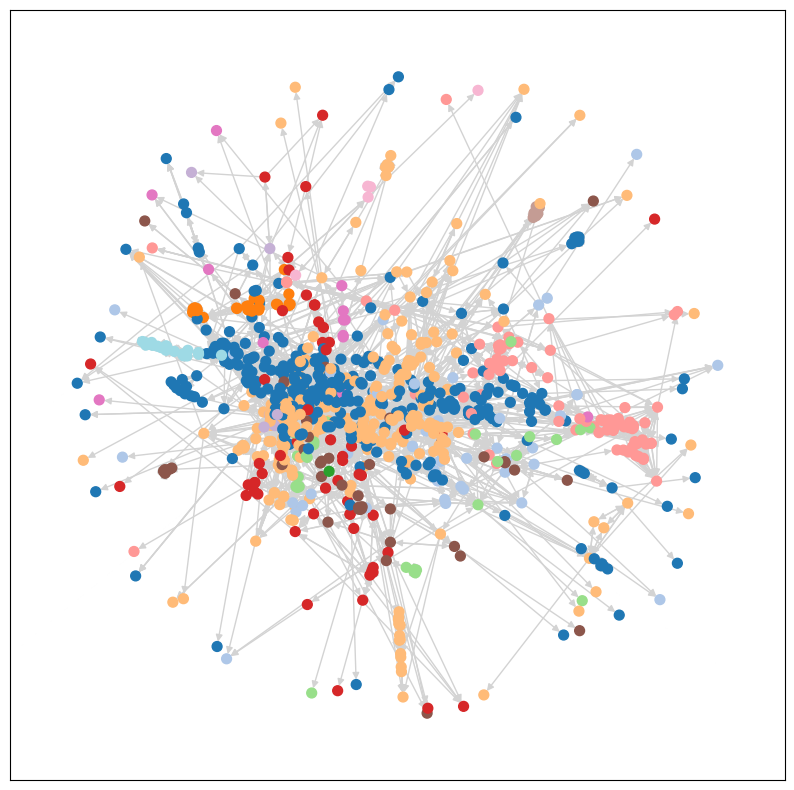

In [54]:
community_ids = [partition[node] for node in sub_G.nodes()]

# Use a color map
cmap = cm.get_cmap('tab20', max(community_ids)+1)

plt.figure(figsize=(10,10))
nx.draw_networkx(
    sub_G,
    node_size=50,
    node_color=community_ids,
    cmap=cmap,
    edge_color='lightgray',
    with_labels=False
)
plt.show()

Same colors represent the same community. Highly dense regions are very close communities. These items are highly co-purchased items. Each color represent different communities. 

The Total Number of Hubs in Network: 265


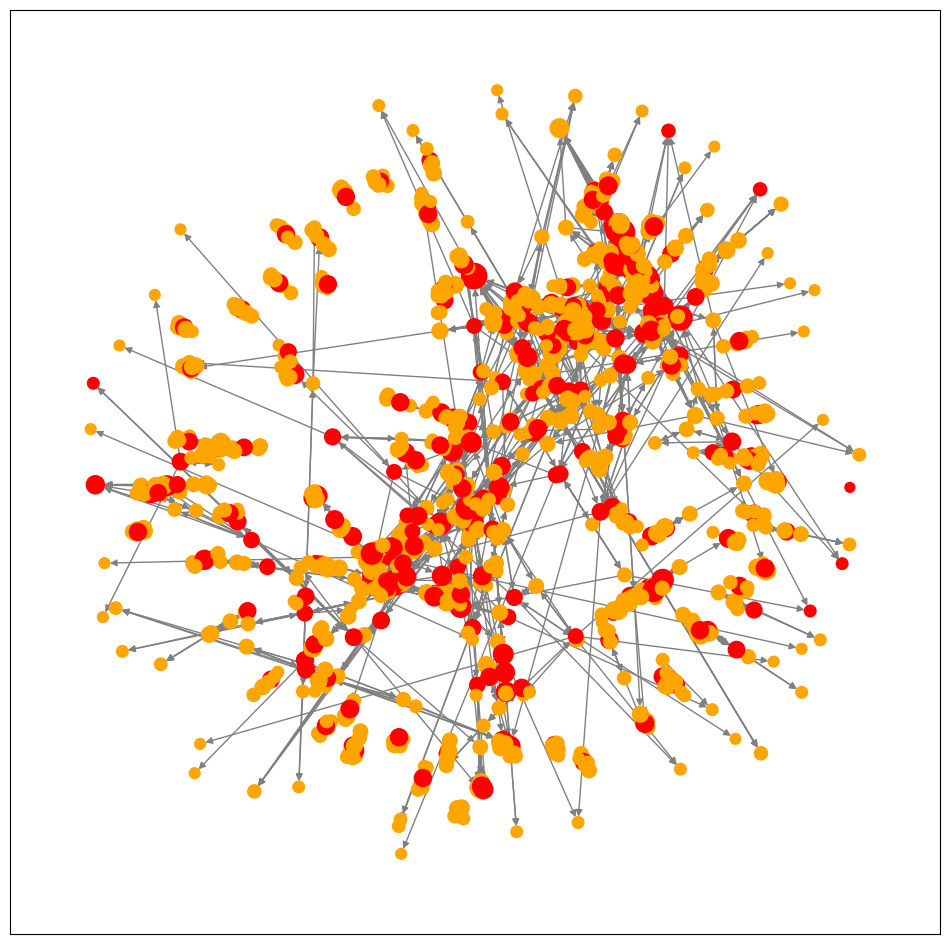

In [55]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

degrees = dict(G.degree())
percentile_99 = np.percentile(list(degrees.values()), 99.9)
hub_nodes = [node for node, deg in degrees.items() if deg >= percentile_99]

print("The Total Number of Hubs in Network:", len(hub_nodes))

hub_subG = G.subgraph(hub_nodes + list(set(n for n in hub_nodes for n in G.neighbors(n)))).copy()

plt.figure(figsize=(12,12))
nx.draw_networkx(
    hub_subG,
    node_size=[50 + 10*hub_subG.degree(n) for n in hub_subG.nodes()],
    node_color=['red' if n in hub_nodes else 'orange' for n in hub_subG.nodes()],
    edge_color='gray',
    with_labels=False
)
plt.show()


Hubs are nodes with very high connectivity compared to the rest of the network. In other words, they have many edges linking them to other nodes.

In network analysis, hubs are critical because they often dominate the flow of information, act as central points for connectivity, and influence the network’s structure.

There are 265 hubs in the most connected %0.05 hubs. These nodes represent the very elite subset of nodes with the highest connectivity. These hubs likely correspond to the most popular items or central items in the network. 

In the plot, red nodes are hubs and orange nodes are neighbors of hubs. Hubs often act as central connectors linking multiple clusters of neighbors. Dense areas indicate communities around certain hubs. This highlights which items/users are influential and can serve as key points for recommendations or interventions.

# Recommendation Systems

## Graph-Based Rec Sys

### Neighbor Algorithm

In [56]:
def recommend_neighbors(G, node, top_k=10):
    # simply recommend top-k successors by degree
    successors = list(G.successors(node))
    sorted_succ = sorted(successors, key=lambda x: G.out_degree(x), reverse=True)
    return sorted_succ[:top_k]


### PageRank Algorithm

In [57]:
def recommend_pagerank(G, node, top_k=10, alpha=0.85):
    """
    Personalized PageRank using NetworkX 3.x
    """
    # Personalization vector: all zeros except 1 for the target node
    personalization = {n: 0 for n in G.nodes()}
    personalization[node] = 1

    # Compute PPR
    pr = nx.pagerank(G, alpha=alpha, personalization=personalization, max_iter=200)

    # Remove the node itself from recommendations
    pr.pop(node, None)

    # Take top-k nodes
    top_nodes = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:top_k]
    return [n for n, _ in top_nodes]

### Evaluation

In [58]:
def precision_at_k(recommended, ground_truth, k):
    recommended_k = recommended[:k]
    hits = len(set(recommended_k) & set(ground_truth))
    return hits / k

def recall_at_k(recommended, ground_truth, k):
    recommended_k = recommended[:k]
    hits = len(set(recommended_k) & set(ground_truth))
    return hits / len(ground_truth) if ground_truth else 0

In [59]:
def evaluate_node(node, G, method='neighbors', top_k=10):
    ground_truth = list(G.successors(node))
    if not ground_truth:
        return None  # skip nodes with no successors
    
    if method == 'neighbors':
        recommended = recommend_neighbors(G, node, top_k)
    elif method == 'pagerank':
        recommended = recommend_pagerank(G, node, top_k)
    else:
        raise ValueError("Method must be 'neighbors' or 'pagerank'")
    
    precision = precision_at_k(recommended, ground_truth, top_k)
    recall = recall_at_k(recommended, ground_truth, top_k)
    return precision, recall

# -------------------------
# Parallel evaluation
# -------------------------
def evaluate_graph_recommendations_parallel(G, target_nodes, method='neighbors', top_k=10, n_jobs=4):
    precisions, recalls = [], []
    with ThreadPoolExecutor(max_workers=n_jobs) as executor:
        futures = {executor.submit(evaluate_node, node, G, method, top_k): node for node in target_nodes}
        for future in as_completed(futures):
            result = future.result()
            if result:
                p, r = result
                precisions.append(p)
                recalls.append(r)
    return np.mean(precisions), np.mean(recalls)

In [60]:
random.seed(42)
target_sample = random.sample(list(G.nodes()), 1000)  # sample 1000 products

# Evaluate Neighborhood-based recommendation
precision_n, recall_n = evaluate_graph_recommendations_parallel(
    G, target_sample, method='neighbors', top_k=10, n_jobs=8
)
print(f"Neighborhood-based RecSys -> Precision@10: {precision_n:.4f}, Recall@10: {recall_n:.4f}")

# Evaluate Personalized PageRank recommendation
precision_ppr, recall_ppr = evaluate_graph_recommendations_parallel(
    G, target_sample, method='pagerank', top_k=10, n_jobs=8
)
print(f"PPR-based RecSys -> Precision@10: {precision_ppr:.4f}, Recall@10: {recall_ppr:.4f}")

Neighborhood-based RecSys -> Precision@10: 0.4780, Recall@10: 1.0000
PPR-based RecSys -> Precision@10: 0.4780, Recall@10: 1.0000


### Recommendation

In [93]:
target = 21

target_name = map_ids_to_names([target])[0]  # pass as a list and get the first element
print(f'target_name: {target_name[0]} ({target_name[1]})')

print('-'*50)

recommendations = recommend_pagerank(G, target, top_k=5)

# Map IDs to names and groups using the function
recommendations_named = map_ids_to_names(recommendations)

print("Recommended products with names and groups:")
print('-'*50)
for name, group in recommendations_named:
    print(f"{name} ({group})")
    print('\n')
    
print('='*50)


target_name: The Time Machine (DVD)
--------------------------------------------------
Recommended products with names and groups:
--------------------------------------------------
Strange Fire: A Novel (Book)


Clockwork Worlds : Mechanized Environments in SF (Contributions to the Study of Science Fiction and Fantasy) (Book)


God Knows Marriage Isn't Always Easy: 12 Ways to Add Zest (God Knows) (Book)


What's Really Wrong With You: A Revolutionary Look at How Muscles Affect Your Health (Book)


Water Touching Stone (Book)




In [94]:
target = 100

target_name = map_ids_to_names([target])[0]  # pass as a list and get the first element
print(f'target_name: {target_name[0]} ({target_name[1]})')

print('-'*50)

recommendations = recommend_pagerank(G, target, top_k=5)

# Map IDs to names and groups using the function
recommendations_named = map_ids_to_names(recommendations)

print("Recommended products with names and groups:")
print('-'*50)
for name, group in recommendations_named:
    print(f"{name} ({group})")
    print('\n')
    
print('='*50)


target_name: Guide to Effective Staff Development in Health Care Organizations : A Systems Approach to Successful Training (J-B AHA Press) (Book)
--------------------------------------------------
Recommended products with names and groups:
--------------------------------------------------
Historia De Cancer De Una Dietista : Informacion & Inspiracion para la Recuperacion & Curacion Sobreviviente de tres canceres (Book)


Year of the Tiger (Book)


An Employee's Guide to Stock Options (Book)


Manic-Depressive Illness (Book)


No One Lives Forever 2: A Spy in H.A.R.M.'s Way : Prima's Official Strategy Guide (Prima's Official Strategy Guides) (Book)




In [97]:
target = 3000

target_name = map_ids_to_names([target])[0]  # pass as a list and get the first element
print(f'target_name: {target_name[0]} ({target_name[1]})')

print('-'*50)

recommendations = recommend_pagerank(G, target, top_k=5)

# Map IDs to names and groups using the function
recommendations_named = map_ids_to_names(recommendations)

print("Recommended products with names and groups:")
print('-'*50)
for name, group in recommendations_named:
    print(f"{name} ({group})")
    print('\n')
    
print('='*50)


target_name: Honda St1100 V-Fours Service and Repair Manual (Haynes Service and Repair Manual Series) (Book)
--------------------------------------------------
Recommended products with names and groups:
--------------------------------------------------
You Can Dance - Lambada (Video)


Beethoven: Violin Sonatas Nos. 5, 9, & 10 (Music)


Sediment Flux Modeling (Environmental Science and Technology: A Wiley-Interscience Series of Texts and Monographs) (Book)


Improving Upper Body Control: An Approach to Assessment and Treatment of Tonal Dysfunction (Book)


Standard Chess Openings (Book)




## ML-Based RecSys

### Feature Engineering & Dataset Preparation

In [62]:
positive_edges = random.sample(list(G.edges()), 50000)

nodes = list(G.nodes())
negative_edges = []
while len(negative_edges) < 50000:
    u, v = random.sample(nodes, 2)
    if not G.has_edge(u, v):
        negative_edges.append((u, v))

edges = positive_edges + negative_edges

# -----------------------------
# 3. PRECOMPUTE NODE FEATURES (FIX)
# -----------------------------
degree = dict(G.degree())
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())
cluster = nx.clustering(G.to_undirected())
pagerank = nx.pagerank(G, alpha=0.85)

# -----------------------------
# 4. Compute pair-level features
# -----------------------------
def compute_pair_features(G, edges):
    data = []
    UG = G.to_undirected()

    # Precompute fast pair metrics
    jaccard = { (u,v): s for u,v,s in nx.jaccard_coefficient(UG, edges) }
    pa = { (u,v): s for u,v,s in nx.preferential_attachment(UG, edges) }

    for u, v in edges:
        feat = {
            "u": u,
            "v": v,
            "label": 1 if G.has_edge(u, v) else 0,

            # Node-level features
            "degree_u": degree[u],
            "degree_v": degree[v],
            "in_degree_u": in_degree[u],
            "in_degree_v": in_degree[v],
            "out_degree_u": out_degree[u],
            "out_degree_v": out_degree[v],
            "clustering_u": cluster[u],
            "clustering_v": cluster[v],
            "pagerank_u": pagerank[u],
            "pagerank_v": pagerank[v],

            # Pair-level features
            "common_neighbors": len(set(G.successors(u)) & set(G.successors(v))),
            "jaccard": jaccard.get((u,v), 0),
            "preferential_attachment": pa.get((u,v), 0)
        }
        data.append(feat)

    return data

# -----------------------------
# 5. Run feature generation
# -----------------------------
features_df = compute_pair_features(G, edges)
print("Pair-level features completed")

Pair-level features completed


In [63]:
features_df = pd.DataFrame(features_df)
features_df.head()

,u,v,label,degree_u,degree_v,in_degree_u,in_degree_v,out_degree_u,out_degree_v,clustering_u,clustering_v,pagerank_u,pagerank_v,common_neighbors,jaccard,preferential_attachment
0,12884,14193,1,13,10,8,5,5,5,0.500000,0.214286,0.000006,0.000004,2,0.230769,64
1,166580,146550,1,11,12,6,7,5,5,0.400000,0.285714,0.000005,0.000005,1,0.181818,42
2,250749,250750,1,11,7,6,2,5,5,0.571429,0.400000,0.000004,0.000002,2,0.200000,35
3,9419,2429,1,11,12,6,7,5,5,0.190476,0.377778,0.000003,0.000006,0,0.062500,70
4,39696,45938,1,17,12,12,7,5,5,0.205128,0.392857,0.000008,0.000005,0,0.235294,104


In [64]:
features_df.to_csv('./graph_ml_dataset.csv')

In [71]:
positives = features_df[features_df['label'] == 1]
negatives = features_df[features_df['label'] == 0]


In [72]:
negatives_sorted = negatives.sort_values(by=['jaccard', 'common_neighbors'], ascending=False)
hard_negatives = negatives_sorted.head(len(positives) * 3)  # 3x positives

df_train = pd.concat([positives, hard_negatives]).sample(frac=1, random_state=42)


In [73]:
df_train = df_train.copy()
df_train["qid"] = df_train["u"]

In [74]:
X = df_train.drop(columns=["u", "v", "label"])
y = df_train["label"]
qids = df_train["qid"]

In [75]:
X_train, X_val, y_train, y_val, qid_train, qid_val = train_test_split(
    X, y, qids, test_size=0.2, random_state=42, stratify=y
)

In [76]:
def qid_to_group(qids):
    _, counts = np.unique(qids, return_counts=True)
    return counts.tolist()

group_train = qid_to_group(qid_train)
group_val   = qid_to_group(qid_val)

### LightGBM Ranker

In [84]:
params = {
    # ---- Core ranking objective ----
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [5, 10, 20],     # evaluate NDCG at specific cutoffs

    # ---- Tree structure ----
    'num_leaves': 128,               # 64 → 128 for more expressiveness
    'max_depth': -1,
    'min_data_in_leaf': 20,          # avoids overfitting groups
    'min_sum_hessian_in_leaf': 1e-3,

    # ---- Boosting ----
    'boosting_type': 'gbdt',
    'n_estimators': 800,             # you can remove if using num_boost_round
    'learning_rate': 0.05,           # LR often higher for ranking
    'num_boost_round': 2000,         # ranking benefits from many rounds

    # ---- Regularization ----
    'lambda_l1': 0.0,
    'lambda_l2': 1.0,
    'min_gain_to_split': 0.0,
    'max_bin': 255,

    # ---- Sampling (important for large imbalanced ranking sets) ----
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.9,

    # ---- Special ranking parameters ----
    'label_gain': [0, 1],            # gains for labels (can do multi-rel)
    'lambdarank_truncation_level': 20,  # reduces noise in pairwise sampling
    'max_position': 20,              # focuses ranking on top-k positions

    # ---- Optimization ----
    'verbosity': -1,
}


In [85]:
clf = lgb.LGBMRanker(**params)


clf.fit(
    X_train, y_train,
    group=group_train,
    eval_set=[(X_val, y_val)],
    eval_group=[group_val],
    eval_metric='ndcg'
)

/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMRanker(bagging_fraction=0.9, bagging_freq=1, feature_fraction=0.9,
           label_gain=[0, 1], lambda_l1=0.0, lambda_l2=1.0,
           lambdarank_truncation_level=20, learning_rate=0.05, max_bin=255,
           max_position=20, metric='ndcg', min_data_in_leaf=20,
           min_gain_to_split=0.0, min_sum_hessian_in_leaf=0.001,
           n_estimators=800, ndcg_eval_at=[5, 10, 20], num_boost_round=2000,
           num_leaves=128, objective='lambdarank', verbosity=-1)

### Evaluation

In [86]:
y_scores = clf.predict(X_val)
y_pred = (y_scores > 0.5).astype(int)

/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


In [87]:
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)

print("LightGBM Model:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")

LightGBM Model:
Precision: 0.9295
Recall:    0.9309
F1-score:  0.9302
Accuracy:  0.9302


In [88]:
y_scores = clf.predict(X_val)   # continuous ranking scores

def precision_recall_at_k(y_true, y_scores, k=10):
    idx = np.argsort(y_scores)[::-1][:k]
    top_k_true = np.array(y_true)[idx]
    precision_at_k = top_k_true.sum() / k
    recall_at_k = top_k_true.sum() / np.sum(y_true)
    return precision_at_k, recall_at_k

precision10, recall10 = precision_recall_at_k(y_val, y_scores, k=10)

print(f"Precision@10: {precision10:.3f}, Recall@10: {recall10:.3f}")


/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


Precision@10: 1.000, Recall@10: 0.001
